In [ ]:
# Copyright (C) 2024 co-pace GmbH (a subsidiary of Continental AG).
# Licensed under the BSD-3-Clause License.
# @author: Jonas Noah Michael Neuhöfer

In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 3
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython import display
import hashlib
import time
from context import filters, visual, eval

emptyfig, emptyax = plt.subplots(figsize=(1,1), dpi=10)

seed = "Random but reproducible seed"
if isinstance(seed, str):
    seed = seed.encode()
    seed = int.from_bytes(seed + hashlib.sha512(seed).digest(), 'big')

- Loading package src
-  Loading package src/filters
-  Loading File 'src/utils.py'
-   Loading File 'abstract.py'
-   Loading File 'distributions.py'
-   Loading File 'models.py'
-   Loading File 'proposed.py'
-   Loading File 'robust.py'
-  Loading package src/visual
-  Loading package src/eval
-   Loading File 'simulate.py'
-   Loading File 'Distr_test.py'
-   Loading File 'Singer_test.py'
-   Loading File 'showcase.py'
-   Loading File 'animations.py'


 ## Introducing the displays
Below you will see an assortment of different graphs, each measuring a certain quality of each filter.

- **The big panel to the left** shows the movement of a simulated agent as well as the estimated trajectory of each filter.<br>

    In each timestep $t$ the state of the agent is described by its positions $p_x$ and $p_y$, which are plotted in this panel,<br>
    its velocity along the coordinate axes $v_x$ and $v_z$ and its acceleration along the axes $a_x$ and $a_z$.<br>
    These follow the stochastic differential equations (with $z = x,y$) with Gaussian white noise $w(t)$
    $$\begin{align*} \dot p_z(t) &= v_z(t) \\ \dot v_z(t) &= -\beta v_z(t) + a_z(t) \\ \dot a_z(t) &= -\alpha a_z(t) +\sigma \cdot w(t) \end{align*}$$

- **The second leftmost top panel** shows the summed processing time of each filtering method.<br>
    This measures only the time spent in the actual filter algorithm (the ``_filter()`` method in our implementations)

- **The second leftmost bottom panel** shows the distribution of the absolute Euclidean error of the filtered position estimates $p_x$ and $p_y$ to the ground truth.<br>
    The boxplots indicate the 5, 25, 50, 75 and 95 percentiles.<br>
    The violin plot in the background gives a more detailed description of the distribution, including minima and maxima.

- **The third leftmost top panel** shows the distribution of the likelihood that the filtered state estimate produced the ground truth. <br>
    Note that the investigation of the Euclidean error of the previous plot neither measures the estimation fidelity of the hidden variables<br>
    of velocity and acceleration nor considers the estimated covariance matrix of the estimate.<br>

    The likelihood is computed by using the density $d_t(\cdot)$ of the state estimate ($p_x(t),p_y(t),v_x(t),v_y(t),a_x(t),a_y(t)$) returned by the filter in each timestep $t$ <br>
    (E.g. for the Kalman filter it would be the multivariate normal density with mean and covariance given by the filtered estimates). <br>
    Thus, the plot describes the distribution of $\{d_t(x_t) | t = 1,...,T\}$, where $\{x_t\}_{t=1}^T$ is the ground truth trajectory.

    The boxplot again indicates the 5, 25, 50, 75 and 95 percentiles.<br>

- **The third leftmost bottom panel** shows the information of the upper panel but is restricted to the position estimate $p_x, p_y$. <br>
    This is motivated by the fact that the hidden variables of velocity and acceleration can only be estimated with a time delay.

- **The fourth leftmost bottom panel** shows the distribution over the number of iterations each filter step required (when the algorithm is an iteration scheme)<br>
    as well as the total number of iterations of each method in parentheses after each method's label.

## Introducing the controls
- **reseed** (button on the far left). Each click of this button cycles through different trajectories.<br>
    The exact sequence depends on the initial seed of the random number generator underlying all further processes,
    which is defined in the first cell.<br> We use the seed 'Random but reproducible seed'. 
- **predict** (field below reseed): The number of steps each filter will predict into the future.<br>
    Good to visualise the estimated velocity and acceleration in the final timestep
- $\boldsymbol{\alpha}$ (first-row parameter): The coefficient controlling the decay of the acceleration in the SDE above.<br>
    $\frac{1}{\alpha}$ can be interpreted as the maneuver time constant, describing how long each maneuver takes.
- **$\boldsymbol\beta$** (first-row parameter): The coefficient controlling the decay of the velocity in the SDE above.<br>
    This controls the friction in the system with $\frac{1}{\beta}$ describing for how long each acceleration in the past still influences the current velocity 
- **Q's $\boldsymbol{\sigma^2}$** (first-row parameter): The square of the coefficient $\sigma$ controlling the magnitude of the random accelerations in the SDE above.
    Affects the magnitude of change between timesteps and acts as a multiplicative factor on the process noise covariance matrix $Q$
- **sensor Nbr** (first-row parameter): The number of sensors, each measuring $p_x, p_y$ independently of each other. <br>
    Important for Student's t-distributed noise, since methods usually assume a multivariate Student's t-distribution, which would not be the case.
- **R deform** (second-row parameter): deforms the observation noise covariance matrix $R$ away from the $2\times 2$ identity matrix. <br>
    instead use the $2\times 2$ diagonal matrix with 1 and $r$ on it's diagonal ($r$ being the chosen parameter here). <br>
    In the case of multiple sensors. Each sensor will have R as an individual observation noise covariance matrix.
- **R phase** (second-row parameter): While the filters assume to have observation noise covariance matrix $diag(1,r)$, <br>
    the observations are actually generated with a rotated version of $R$. Rotated by $\phi \cdot 360°$ degrees to be precise.
- **R's $\boldsymbol{\sigma^2}$** (second-row parameter): additional scaling of the covariance matrix $R$. <br>
    Note that we further scale $R$ by the average distance traveled by the agent per second, such that the spread of observation outliers <br>
    is comparable for different dynamic model parameters
- **Obs. dist.** (second-row parameter): The distribution of the observation noise. Either multivariate ``Normal`` or ``Student-t``.
- **R's $\boldsymbol\nu$** (third-row parameter): If the observation noise is Student's t-distributed, controls the degrees of freedom $\nu$ of the distribution. <br>
    This controls how frequent and how distant outliers are from the ground truth. A low parameter induces more and farther outliers.
- **Nbr steps** (third-row parameter): How many timesteps are sampled
- **$\boldsymbol{\Delta t}$** (third-row parameter): The duration between two timesteps
- **skip obs** (third-row parameter): The filters will only receive every $k^{\text{th}}$ observation with $k$ being this parameter.


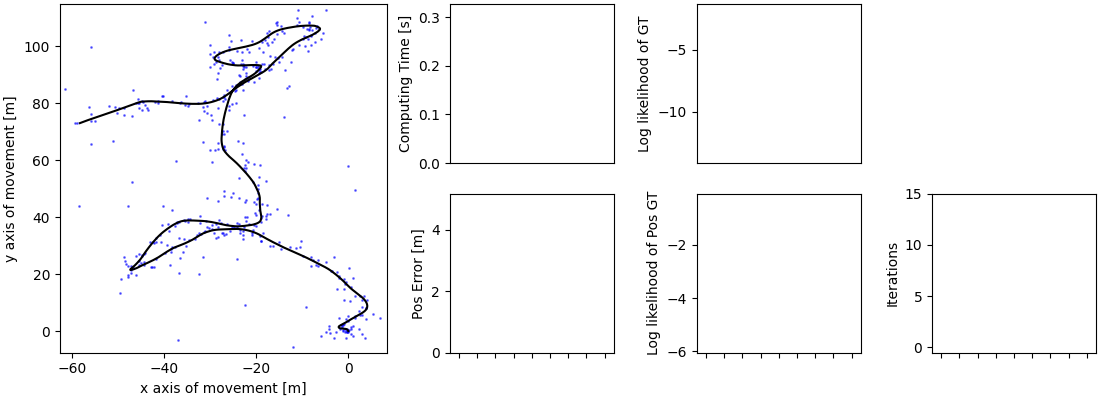

In [2]:
fig = plt.figure(constrained_layout=True, figsize=(11,4), dpi=100)
trajectory_ax = fig.add_subplot(2,5,(1,7))
time_ax       = fig.add_subplot(2,5,3)
error_ax      = fig.add_subplot(2,5,8)
likelihood_ax = fig.add_subplot(2,5,4)
likelihood_pos_ax = fig.add_subplot(2,5,9)
iter_ax       = fig.add_subplot(2,5,10)
trajectory_ax.set_xlabel("x axis of movement [m]", fontsize=10)
trajectory_ax.set_ylabel("y axis of movement [m]", fontsize=10)
time_ax.set_xticks([],[])
time_ax.set_ylabel("Computing Time [s]", fontsize=10)
time_ax.set_ylim(0,0.3)
error_ax.set_xticks([],[])
#error_ax.set_yscale("log")
error_ax.set_ylim(0,4)
error_ax.set_ylabel("\nPos Error [m]")
likelihood_ax.set_ylim(-4,1)
#likelihood_ax.set_yscale("log")
likelihood_ax.set_ylabel("\nLog likelihood of GT")
likelihood_ax.set_xticks([],[])
likelihood_pos_ax.set_ylim(-15,3)
#likelihood_pos_ax.set_yscale("log")
likelihood_pos_ax.set_ylabel("\nLog likelihood of Pos GT")
likelihood_pos_ax.set_xticks([],[])
iter_ax.set_ylabel("\nIterations")
iter_ax.set_ylim(-0.5,15)
iter_ax.set_xticks([],[])

ModelManager = visual.showcase.ExtendedSingerModelManager( seed = seed,
    trajectory_ax = trajectory_ax, Model_params = visual.showcase.ExtendedSingerModelParameters)

#displays only a subset of the available filters
#can be changed at will
FilterList = [visual.showcase.FilterList[i] for i in [0,1,5,6,8,9,10,11,12]]
model_boxes = []
FilterManagers = {}
for i in range(len(FilterList)):
    filterclass, style, params, paramFct = FilterList[i]
    new_WM = visual.showcase.FilterManager(filterclass=filterclass, style=style, params=params,
                            paramFct=paramFct, index=i, modelmanager=ModelManager, emptyax=emptyax, 
                            trajectory_ax=trajectory_ax, time_ax=time_ax, error_ax=error_ax, 
                            likelihood_ax=likelihood_ax, likelihood_pos_ax=likelihood_pos_ax, 
                            iter_ax=iter_ax)
    FilterManagers[filterclass] = new_WM
    model_boxes.append(new_WM.widget_box)
#for filtermanager in FilterManagers.values():
#    filtermanager.switch_visibility()

display.display_markdown(
r""" ## Introducing the displays
Below you will see an assortment of different graphs, each measuring a certain quality of each filter.

- **The big panel to the left** shows the movement of a simulated agent as well as the estimated trajectory of each filter.<br>

    In each timestep $t$ the state of the agent is described by its positions $p_x$ and $p_y$, which are plotted in this panel,<br>
    its velocity along the coordinate axes $v_x$ and $v_z$ and its acceleration along the axes $a_x$ and $a_z$.<br>
    These follow the stochastic differential equations (with $z = x,y$) with Gaussian white noise $w(t)$
    $$\begin{align*} \dot p_z(t) &= v_z(t) \\ \dot v_z(t) &= -\beta v_z(t) + a_z(t) \\ \dot a_z(t) &= -\alpha a_z(t) +\sigma \cdot w(t) \end{align*}$$

- **The second leftmost top panel** shows the summed processing time of each filtering method.<br>
    This measures only the time spent in the actual filter algorithm (the ``_filter()`` method in our implementations)

- **The second leftmost bottom panel** shows the distribution of the absolute Euclidean error of the filtered position estimates $p_x$ and $p_y$ to the ground truth.<br>
    The boxplots indicate the 5, 25, 50, 75 and 95 percentiles.<br>
    The violin plot in the background gives a more detailed description of the distribution, including minima and maxima.

- **The third leftmost top panel** shows the distribution of the likelihood that the filtered state estimate produced the ground truth. <br>
    Note that the investigation of the Euclidean error of the previous plot neither measures the estimation fidelity of the hidden variables<br>
    of velocity and acceleration nor considers the estimated covariance matrix of the estimate.<br>

    The likelihood is computed by using the density $d_t(\cdot)$ of the state estimate ($p_x(t),p_y(t),v_x(t),v_y(t),a_x(t),a_y(t)$) returned by the filter in each timestep $t$ <br>
    (E.g. for the Kalman filter it would be the multivariate normal density with mean and covariance given by the filtered estimates). <br>
    Thus, the plot describes the distribution of $\{d_t(x_t) | t = 1,...,T\}$, where $\{x_t\}_{t=1}^T$ is the ground truth trajectory.

    The boxplot again indicates the 5, 25, 50, 75 and 95 percentiles.<br>

- **The third leftmost bottom panel** shows the information of the upper panel but is restricted to the position estimate $p_x, p_y$. <br>
    This is motivated by the fact that the hidden variables of velocity and acceleration can only be estimated with a time delay.

- **The fourth leftmost bottom panel** shows the distribution over the number of iterations each filter step required (when the algorithm is an iteration scheme)<br>
    as well as the total number of iterations of each method in parentheses after each method's label.

## Introducing the controls
- **reseed** (button on the far left). Each click of this button cycles through different trajectories.<br>
    The exact sequence depends on the initial seed of the random number generator underlying all further processes,
    which is defined in the first cell.<br> We use the seed 'Random but reproducible seed'. 
- **predict** (field below reseed): The number of steps each filter will predict into the future.<br>
    Good to visualise the estimated velocity and acceleration in the final timestep
- $\boldsymbol{\alpha}$ (first-row parameter): The coefficient controlling the decay of the acceleration in the SDE above.<br>
    $\frac{1}{\alpha}$ can be interpreted as the maneuver time constant, describing how long each maneuver takes.
- **$\boldsymbol\beta$** (first-row parameter): The coefficient controlling the decay of the velocity in the SDE above.<br>
    This controls the friction in the system with $\frac{1}{\beta}$ describing for how long each acceleration in the past still influences the current velocity 
- **Q's $\boldsymbol{\sigma^2}$** (first-row parameter): The square of the coefficient $\sigma$ controlling the magnitude of the random accelerations in the SDE above.
    Affects the magnitude of change between timesteps and acts as a multiplicative factor on the process noise covariance matrix $Q$
- **sensor Nbr** (first-row parameter): The number of sensors, each measuring $p_x, p_y$ independently of each other. <br>
    Important for Student's t-distributed noise, since methods usually assume a multivariate Student's t-distribution, which would not be the case.
- **R deform** (second-row parameter): deforms the observation noise covariance matrix $R$ away from the $2\times 2$ identity matrix. <br>
    instead use the $2\times 2$ diagonal matrix with 1 and $r$ on it's diagonal ($r$ being the chosen parameter here). <br>
    In the case of multiple sensors. Each sensor will have R as an individual observation noise covariance matrix.
- **R phase** (second-row parameter): While the filters assume to have observation noise covariance matrix $diag(1,r)$, <br>
    the observations are actually generated with a rotated version of $R$. Rotated by $\phi \cdot 360°$ degrees to be precise.
- **R's $\boldsymbol{\sigma^2}$** (second-row parameter): additional scaling of the covariance matrix $R$. <br>
    Note that we further scale $R$ by the average distance traveled by the agent per second, such that the spread of observation outliers <br>
    is comparable for different dynamic model parameters
- **Obs. dist.** (second-row parameter): The distribution of the observation noise. Either multivariate ``Normal`` or ``Student-t``.
- **R's $\boldsymbol\nu$** (third-row parameter): If the observation noise is Student's t-distributed, controls the degrees of freedom $\nu$ of the distribution. <br>
    This controls how frequent and how distant outliers are from the ground truth. A low parameter induces more and farther outliers.
- **Nbr steps** (third-row parameter): How many timesteps are sampled
- **$\boldsymbol{\Delta t}$** (third-row parameter): The duration between two timesteps
- **skip obs** (third-row parameter): The filters will only receive every $k^{\text{th}}$ observation with $k$ being this parameter.
""", raw=True)
ModelManager.show_params()


In [3]:
time.sleep(0.5)
display.display(widgets.VBox(model_boxes))